Read satellite data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
def read_satellite_data(veg_type, satellite):
    # Load vegetation class table
    veg_class = pd.read_csv('../data/veg_class_data/tables/veg_class.csv')
    df_satellite = pd.read_csv(f'../data/satellite_data/tables/phenology_climate/{satellite}.csv')
    df = pd.merge(df_satellite, veg_class, on=['latitude', 'longitude'], how='inner')
    # Filter for Forest classes
    if veg_type in (11, 12, 13, 14):
        df = df[df['veg_class'].isin([veg_type])]#.iloc[0:1000]
    else:
        df = df[df['veg_class'].isin([11, 12, 13, 14])]#.iloc[0:1000]

    # print(df)
    
    # Separate climate/phenology columns by type
    eos_cols = [col for col in df.columns if 'eos' in col]
    t_cols = [col for col in df.columns if 'annual_t' in col]
    p_cols = [col for col in df.columns if 'annual_p' in col]
    sos_cols = [col for col in df.columns if 'sos' in col]

    # === Period 1: 2001–2007 ===
    if satellite == "avhrr":
        years = [str(y) for y in range(1982, 2017)]
    elif satellite == "modis":
        years = [str(y) for y in range(2001, 2024)]
        # Build boolean masks
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
    else:
        years = [str(y) for y in range(2013, 2023)]
        mask_sos = (df[sos_cols] < 0).any(axis=1)      # True if any sos < 0
        mask_eos = (df[eos_cols] > 365).any(axis=1)    # True if any eos > 365
        # Keep only rows that do NOT violate the conditions
        df = df[~(mask_sos | mask_eos)].copy()
        
    cols = years
    df = df[[col for col in eos_cols + t_cols + p_cols + sos_cols if any(y in col for y in cols)] + ['latitude', 'longitude', 'veg_class']].copy()
    t_cols_df = [col for col in df.columns if 'annual_t' in col]
    df[t_cols_df] = df[t_cols_df] - 273.5  # Convert temperature
    df.columns = df.columns.str.replace(r'\D*(\d{4})$', lambda m: f"{m.group(0)[0:-4]}{m.group(1)}", regex=True)
    df['annual_t'] = df[[col for col in df.columns if 'annual_t' in col]].mean(axis=1)
    df['annual_p'] = df[[col for col in df.columns if 'annual_p' in col]].mean(axis=1)
    df['eos'] = df[[col for col in df.columns if 'eos' in col]].mean(axis=1)
    df['sos'] = df[[col for col in df.columns if 'sos' in col]].mean(axis=1)
    return df

In [4]:
## Plot EOS turning point for each forest type
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_mean_eos_by_temp_precip(df, temp_col, precip_col,
                                 eos_col, precip_threshold):
    df = df.copy()

    # Divide into two groups based on threshold
    df['precip_bin'] = np.where(df[precip_col] <= precip_threshold, 0, 1)
    bins = sorted(df['precip_bin'].dropna().unique())

    fig, ax = plt.subplots(figsize=(6, 4))

    for bin_val in bins:
        sub_df = df[df['precip_bin'] == bin_val].copy()
        if len(sub_df) < 5:
            continue

        # Bin temperature into 0.1°C steps and filter sparse bins
        sub_df['temp_1C_bin'] = np.floor(sub_df[temp_col] * 10) / 10
        counts = sub_df['temp_1C_bin'].value_counts()
        valid_bins = counts[counts >= 10].index
        filtered_df = sub_df[sub_df['temp_1C_bin'].isin(valid_bins)]
        if len(filtered_df) < 5:
            continue

        # Prepare raw and mean trend data
        raw_x = filtered_df[temp_col].values
        raw_y = filtered_df[eos_col].values

        grouped = filtered_df.groupby('temp_1C_bin')[eos_col]
        mean_eos = grouped.mean()
        std_eos = grouped.std()

        x = mean_eos.index.values
        y = mean_eos.values
        yerr = std_eos.values

        if len(x) < 5:
            continue

        # # --- Gray reference line (ONLY mean EOS, no regression, no shading) ---
        # ax.plot(x, y, color='gray', lw=2, linestyle='-', label='Mean EOS (gray)')
        def format_p(p):
            if p < 0.01:
                return "p<0.01"
            elif p < 0.05:
                return "p<0.05"
            else:
                return f"p={p:.2f}"
            
        # --- Red mean EOS (with regression + error shading) ---
        if bin_val == 0:
            ax.plot(x, y, color='#e03c31', lw=2, label='Mean EOS (red)')
            ax.fill_between(x, y - yerr, y + yerr, color='#e03c31', alpha=0.2, label='±1 Std. Dev. (red)')
        
         
            # Detect peak in the 6–8°C window (only for red line)
            peak_candidates = (x >= 6.0) & (x <= 8.0)
            if not np.any(peak_candidates):
                continue
            peak_idx = np.argmax(y[peak_candidates])
            peak_x_vals = x[peak_candidates]
            bp = peak_x_vals[peak_idx]  # Breakpoint
    
            ax.set_ylim(240, 320)
            ax.axvline(x=bp, color='black', linestyle='--', label='Breakpoint (peak)')
            ax.text(bp - 0.5, 300, f'{bp:.2f}°C', color='black', fontsize=12, ha='center')
    
            # --- Regression only for red line ---
            left_mask = raw_x <= bp
            right_mask = raw_x > bp
    
            right_bins = np.floor(raw_x[right_mask] * 10) / 10
            unique_right_bins = np.unique(right_bins)
    
            if len(unique_right_bins) < 5:
                # Not enough bins on right → single regression
                slope, intercept, r_value, p_value, std_err = linregress(raw_x, raw_y)
                x_all = np.linspace(raw_x.min(), raw_x.max(), 100)
                y_all = slope * x_all + intercept
                ax.plot(x_all, y_all, color='black', linestyle='--',
                        label=f'Slope={slope:.2f}, p={p_value:.2f}')
            else:
                # Enough bins → split regression
                slope1, intercept1, r_value1, p_value1, std_err1 = linregress(raw_x[left_mask], raw_y[left_mask])
                slope2, intercept2, r_value2, p_value2, std_err2 = linregress(raw_x[right_mask], raw_y[right_mask])
    
                x_left = np.linspace(raw_x[left_mask].min(), raw_x[left_mask].max(), 50)
                y_left = slope1 * x_left + intercept1
                ax.plot(x_left, y_left, color='black', linestyle='--',
                        label=f'Left slope={slope1:.2f}, p={p_value1:.2f}')
    
                x_right = np.linspace(raw_x[right_mask].min(), raw_x[right_mask].max(), 50)
                y_right = slope2 * x_right + intercept2
                ax.plot(x_right, y_right, color='black', linestyle='--',
                        label=f'Right slope={slope2:.2f}, p={p_value2:.2f}')
                ax.text(0.35, 0.1, f'Slope={slope1:.2f}\nR={r_value1:.2f}\n{format_p(p_value1)}',
                transform=ax.transAxes, fontsize=10, ha='right', va='bottom')
                ax.text(0.75, 0.1, f'Slope={slope2:.2f}\nR={r_value1:.2f}\n{format_p(p_value2)}',
                transform=ax.transAxes, fontsize=10, ha='right', va='bottom')
        else:
            ax.plot(x, y, color='gray', lw=2, label='Mean EOS (red)')
            ax.fill_between(x, y - yerr, y + yerr, color='gray', alpha=0.2, label='±1 Std. Dev. (red)')
    ax.set_ylim(240, 340)   # y-axis from 240 to 320
    ax.set_xlabel("MAT (°C)", fontsize=14)
    ax.set_ylabel("EOS (DOY)", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_xticks([0, 10, 20])
    ax.set_yticks([240, 260, 280, 300, 320, 340])
    from matplotlib.lines import Line2D
    # Custom legend handles with colored lines (no markers)
    custom_legend = [
        Line2D([0], [0], color='gray', lw=5, label='Wet regions'),
        Line2D([0], [0], color='#e03c31', lw=5, label='Dry regions'),
    ]
    # Add legend with formatting
    leg = plt.legend(
        handles=custom_legend,
        fontsize=10,
        frameon=False,       # Remove legend box, optional
        loc='upper left',    # fixed location: upper left
        handlelength=1.0,    # Shorter line length
        handleheight=0.8     # More compact spacing
    )
    # Thicker legend lines (already set via lw=5, but this is redundant safety)
    for line in leg.get_lines():
        line.set_linewidth(7)
    plt.tight_layout()
    return fig


Plot Extended Fig. 3

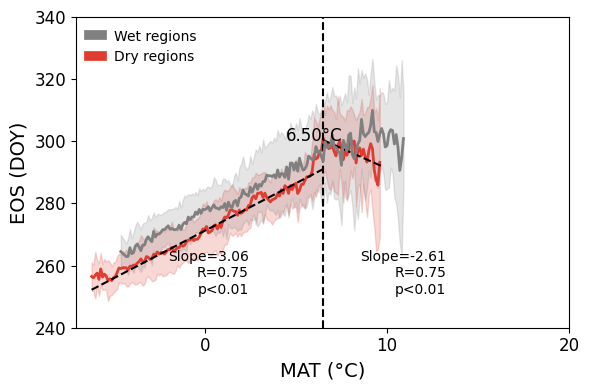

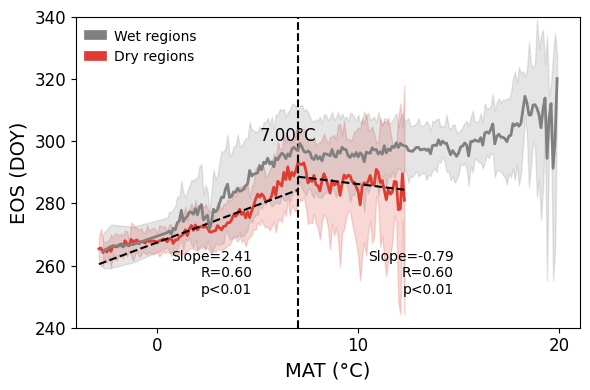

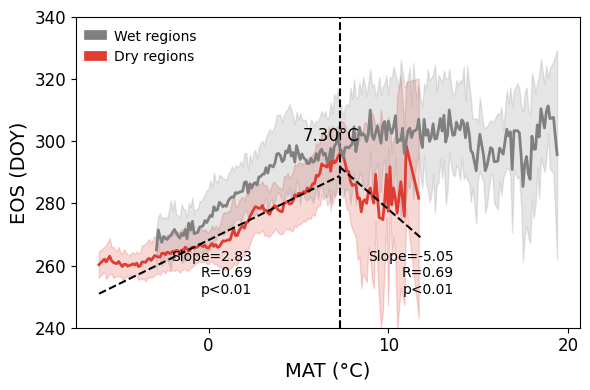

In [5]:
satellite = 'avhrr'

min_z_count = 0
veg_type = 0
df = read_satellite_data(veg_type, satellite)
df = df[
    (df['annual_t'] >= -20) & (df['annual_t'] <= 20) &
    (df['annual_p'] >= 0) & (df['annual_p'] <= 4)
]

fig1 = plot_mean_eos_by_temp_precip(df[df['veg_class'] == 11], 'annual_t', 'annual_p', 'eos', 0.9)
fig2 = plot_mean_eos_by_temp_precip(df[df['veg_class'] == 13], 'annual_t', 'annual_p', 'eos', 0.9)
fig3 = plot_mean_eos_by_temp_precip(df[df['veg_class'] == 14], 'annual_t', 'annual_p', 'eos', 1.0)

fig1.savefig(f"../results/ed_figures/ed_fig3/eos_EN.png", dpi=300, bbox_inches='tight')
fig2.savefig(f"../results/ed_figures/ed_fig3/eos_DB.png", dpi=300, bbox_inches='tight')
fig3.savefig(f"../results/ed_figures/ed_fig3/eos_MF.png", dpi=300, bbox_inches='tight')